In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm
from scipy import stats

import os
import math

import plotly.graph_objs as go

import platform

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

from skimage.morphology  import remove_small_objects
from skimage import color
from PIL import Image

from matplotlib.colors import hsv_to_rgb

flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

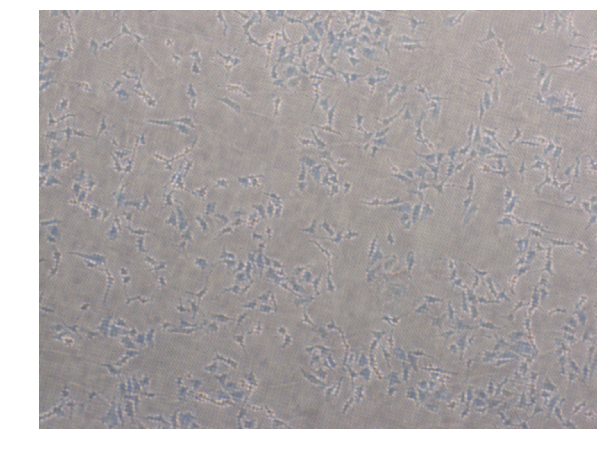

In [2]:
image = cv2.imread('/Users/carolinemccue/Documents/GitHub/CellML/notebooks/ConstantForceShearAnalysis/5um1/20.32ml.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.GaussianBlur(image,(13,13),0)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image)
plt.show()

r, g, b = cv2.split(image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection='3d')

pixel_colors = image.reshape((np.shape(image)[0]*np.shape(image)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [3]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection='3d')

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

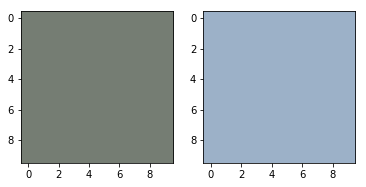

In [4]:
colormin = (75, 20, 125)
colormax = (150, 55, 200)

min_square = np.full((10, 10, 3), colormin, dtype=np.uint8) / 255.0
max_square = np.full((10, 10, 3), colormax, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(min_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(max_square))
plt.show()

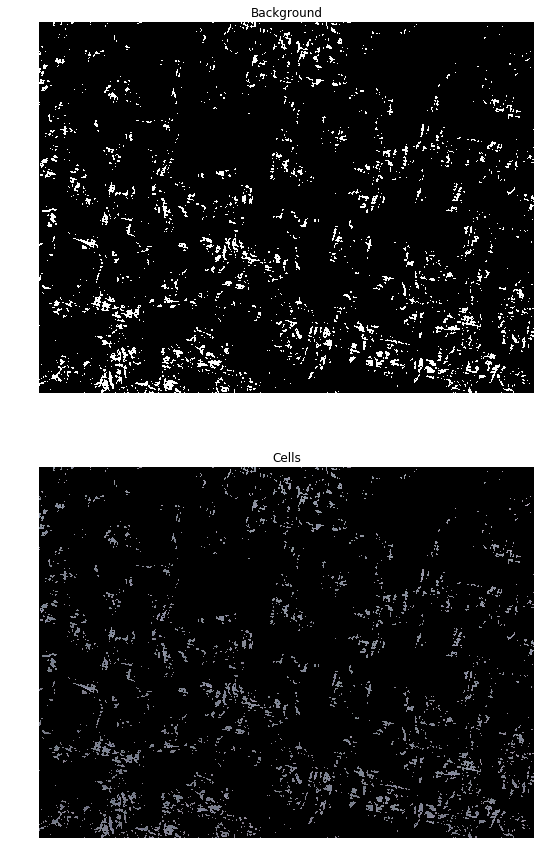

In [5]:
mask = cv2.inRange(hsv_image, colormin, colormax)
result = cv2.bitwise_and(image, image, mask=mask)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(mask, cmap="gray")
ax[0].set_title('Background')
ax[1].imshow(result)
ax[1].set_title('Cells')

for a in ax:
    a.set_axis_off()
plt.show()

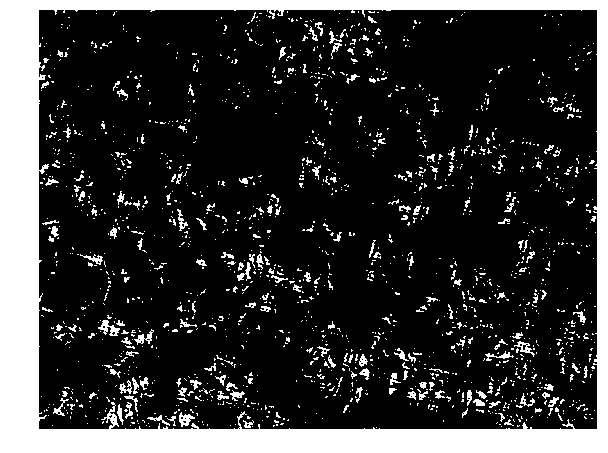

In [6]:
rgbresult = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)
resultgray = color.rgb2gray(rgbresult)

retVal, resultbw = cv2.threshold(resultgray, 0, 120, cv2.THRESH_BINARY)
resultbw = resultbw.astype(np.uint8)

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(resultbw, cmap='gray')
plt.show()

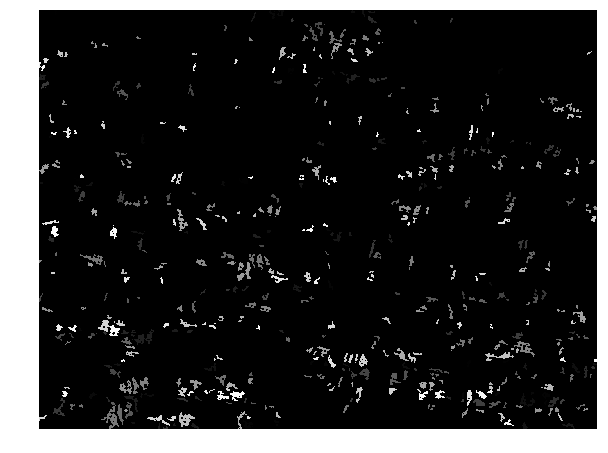

In [7]:
noise = skimage.measure.label(resultbw)
removeposts = morphology.remove_small_objects(noise, min_size=75)
removeposts = removeposts.astype(np.uint8)

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(removeposts, cmap='gray', vmin=0, vmax=255, interpolation='nearest')
plt.show()

In [8]:
cellarea = np.sum(removeposts > 0)
background = np.sum(removeposts == 0)
cellpercent = cellarea / (cellarea + background)
print(cellpercent)

0.04618706597222222


In [9]:
video_path = '/Users/carolinemccue/Documents/GitHub/CellML/notebooks/ConstantForceShearAnalysis/5um1/5um_1.5nN.m4v'
frames_per_second = 1

cam = cv2.VideoCapture(video_path)
frame_list = []
frame_rate = cam.get(cv2.CAP_PROP_FPS) #video frame rate
time_list = []

current_frame = 0

# create directory if it does not exist
images_path = f'./ConstantForceShearAnalysis/5um1/images'
if not os.path.exists(images_path):
    os.makedirs(images_path)

if frames_per_second > frame_rate or frames_per_second == -1:
    frames_per_second = frame_rate

while(True):

    # reading from frame
    ret,frame = cam.read()

    if ret:

        # if video is still left continue creating images
        file_name = f'{images_path}/frame_' + str(current_frame) + '.jpg'
        #print ('Creating...' + file_name)
        #print('frame rate', frame_rate)

        if current_frame % (math.floor(frame_rate/frames_per_second)) == 0:

            # adding frame to list
            frame_list.append(frame)

            # writing selected frames to images_path
            cv2.imwrite(file_name, frame)


        # increasing counter so that it will
        # show how many frames are created
        current_frame += 1
    else:
        break

# Release all space and windows once done
cam.release()
cv2.destroyAllWindows()


In [10]:
images_path = f'./ConstantForceShearAnalysis/5um1/images'

cellarea_list = []

for image_file in os.listdir(images_path):

    input_path = os.path.join(images_path, image_file)
    frame = cv2.imread(input_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    frame = cv2.GaussianBlur(frame,(13,13),0)
    
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_frame, colormin, colormax)
    result = cv2.bitwise_and(frame, frame, mask=mask)

    resultgray = color.rgb2gray(result)

    retVal, resultbw = cv2.threshold(resultgray, 0, 120, cv2.THRESH_BINARY)
    resultbw = resultbw.astype(np.uint8)

    noise = skimage.measure.label(resultbw)
    removeposts = morphology.remove_small_objects(noise, min_size=75)
    removeposts = removeposts.astype(np.uint8)

    cellarea = np.sum(removeposts > 0)
    background = np.sum(removeposts == 0)
    cellpercent = cellarea / (cellarea + background)
    
    cellarea_list.append(cellpercent)
    time = int((image_file.split('_')[1]).split('.')[0])
    time = time / frame_rate
    time_list.append(time)

In [11]:
df = pd.DataFrame()
df['Time'] = time_list
df['Area'] = cellarea_list
df = df.sort_values(by=['Time'], ascending=True)
df['Area_Normalized'] = df['Area'] / df['Area'].iloc[2]
df[(np.abs(stats.zscore(df['Area_Normalized'])) < 3)]
df = df[df['Area_Normalized'] <= 1]
df = df[df['Time'] <= 90.5]
df

,Time,Area,Area_Normalized
60,1.921601,0.020951,1.000000
19,2.882401,0.020100,0.959379
4,3.843202,0.020235,0.965836
110,4.804002,0.020562,0.981425
114,5.764803,0.020300,0.968909
42,6.725603,0.020421,0.974709
28,7.686403,0.019507,0.931084
2,10.568805,0.018910,0.902565
106,11.529605,0.018122,0.864948
82,12.490406,0.017096,0.815972


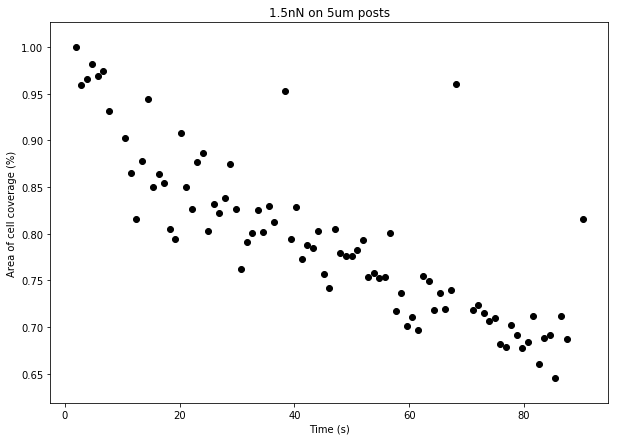

In [12]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

plt.scatter(df['Time'], df['Area_Normalized'], color='k')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Area of cell coverage (%)')
ax.set_title('1.5nN on 5um posts')
#plt.legend()
     
# show plot
plt.show()

In [14]:
df['Area_Normalized'].iloc[-2]

0.6877913199599488